# Fake news detector

The objective of this work is to use Machine learning to predict if the news is True or Fake.

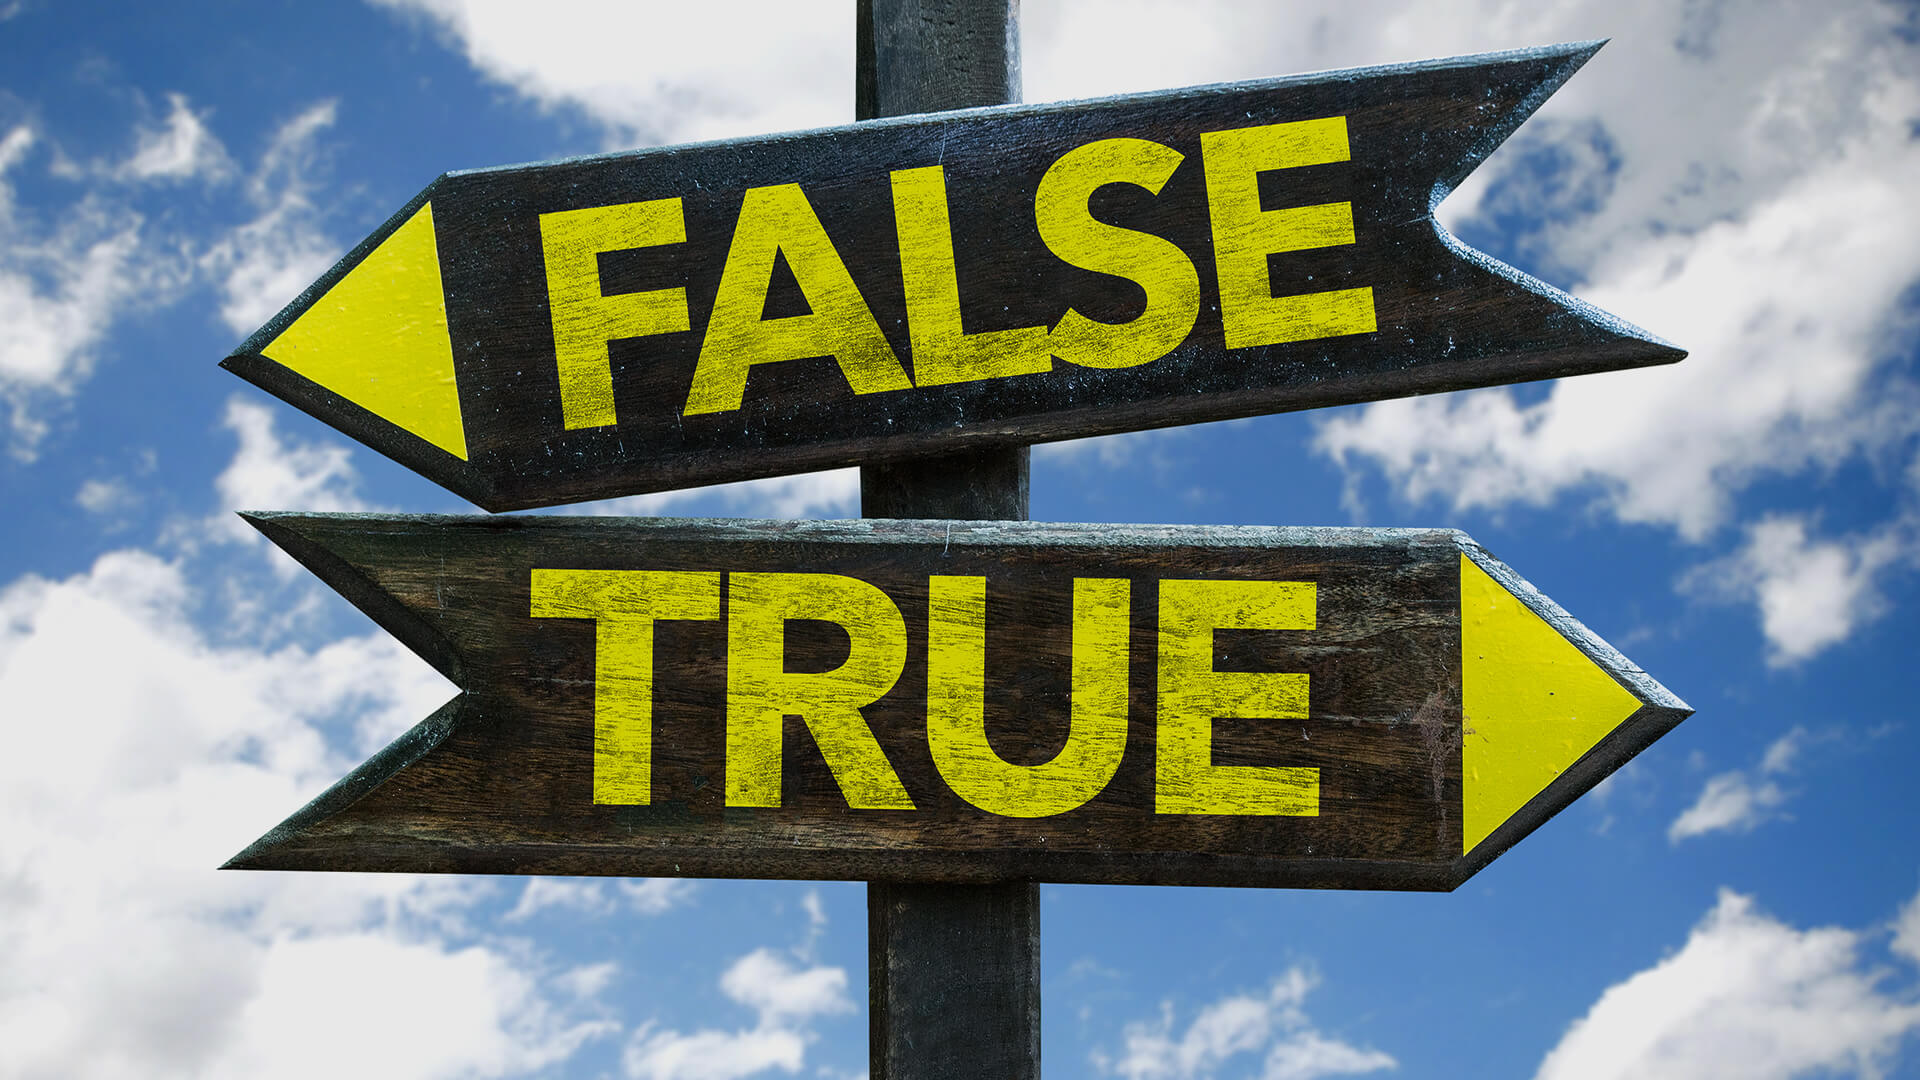

Let's begin importing pandas.

In [ ]:
import pandas as pd

In [ ]:
#Loading the datasets

true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

In [ ]:
true_df.head()

In [ ]:
fake_df.head()

In [ ]:
#Creating 'check' on both dfs that will be the target feature.

true_df['check'] = 'TRUE'
fake_df['check'] = 'FAKE'

In [ ]:
true_df.head()

In [ ]:
fake_df.head()

In [ ]:
true_df.describe()

In [ ]:
fake_df.describe()

Now we will combine both dataset and in the next step we will check it shuffled.

In [ ]:
#We will combine both dfs.

df_news = pd.concat([true_df, fake_df])

In [ ]:
df_news.head(30)

In [ ]:
df_news.info()

In [ ]:
#Shuffling to see some Fakes

df_news.sample(frac = 1)

In [ ]:
#Searching for null values.

df_news.isna().sum()

In [ ]:
#We will join title, text and subject to create the article feature
df_news['article'] = df_news['title']+""+df_news['text']+""+['subject']

In [ ]:
#Creating the final Dataframe with article and check.

df = df_news[['article','check']]

In [ ]:
#Converting to lower case

df['article'] = df['article'].apply(lambda x: x.lower())

In [ ]:
df['article'].head()

In [ ]:
#Removing punctuation

import string

def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [ ]:
df['article'] = df['article'].apply(punctuation_removal)
df['article'].head()

In [ ]:
#Removing stopwords

from nltk.corpus import stopwords
stop = stopwords.words('english')

df['article'].apply(lambda x: [item for item in x if item not in stop])

In [ ]:
df['article']

Visualizing the data with Wordcloud.

In [ ]:
%matplotlib inline

from wordcloud import WordCloud

all_words = ' '.join([text for text in df.article])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We will divide the data in to fake and true. 

In [ ]:
#Function to generate wordcloud to True news.

def wordcloud_true(text, column_text):
    true_text = text.query("check == 'TRUE'")
    all_words = ' '.join([text for text in true_text[column_text]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
#Function to generate wordcloud to Fake news.

def wordcloud_fake(text, column_text):
    fake_text = text.query("check == 'FAKE'")
    all_words = ' '.join([text for text in fake_text[column_text]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
#Wordcloud of the true news.

wordcloud_true(df, "article")

In [ ]:
#Wordcloud of the fake news.

wordcloud_fake(df, "article")

Now we will plot the pareto chart to better visualize the frequencies of the words.

In [ ]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

In [ ]:
import seaborn as sns
import nltk
    
def pareto(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.show()

In [ ]:
#The 20 more frequent words.

pareto(df, "article", 20)

Lemmatization was taking several hours to execute so I decided to comment in this frist version.

In [ ]:
#Lemmatization

'''from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in df["article"]]

df['article'] = df["article"].apply(lemmatize_text)'''

We will create the BOW and the TF-IDF.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#Creating the bag of words
bow_article = CountVectorizer().fit(df['article'])

article_vect = bow_article.transform(df['article'])

In [ ]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(article_vect)
news_tfidf = tfidf_transformer.transform(article_vect)
print(news_tfidf.shape)

Now We will try some models.

In [ ]:
#We will use 20% of the data to train the models.

from sklearn.model_selection import train_test_split
X = news_tfidf
y = df['check']



X_train, X_test, Y_train,Y_test= train_test_split(X, y, test_size=0.2)

Let's try the Naive Bayes.

In [ ]:
#Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

fakenews_detector = MultinomialNB().fit(X_train, Y_train)

In [ ]:
#Model Evaluation
predictions = fakenews_detector.predict(X_test)
print(predictions)

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(Y_test, predictions))

Support Vector Machine.

In [ ]:
from sklearn.linear_model import SGDClassifier

fake_detector_svc = SGDClassifier().fit(X_train, Y_train)

In [ ]:
prediction_svc = fake_detector_svc.predict(X_test)

In [ ]:
print (classification_report(Y_test, prediction_svc))

Logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression

fake_detector_logistic = LogisticRegression().fit(X_train, Y_train)

In [ ]:
predictions_log_reg = fake_detector_logistic.predict(X_test)
print (classification_report(Y_test, predictions_log_reg))